In [5]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception

###
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

Distiller Class

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define Xception base model
xception_base = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create the teacher model
teacher = models.Sequential([
    xception_base,                    # Xception base model
    layers.GlobalAveragePooling2D(), # Reduces dimensionality (spatial pooling)
    layers.Dropout(0.2),             # Dropout to prevent overfitting
    layers.Dense(1024, activation='relu'), # Fully connected layer with ReLU activation
    layers.Dropout(0.2),             # Dropout
    layers.Dense(512, activation='relu'),  # Another dense layer with ReLU
    layers.Dense(5, activation='softmax')  # Final output layer (assuming 5 classes)
])

# Create the student model
student = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(16, (5, 5), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(48, (3, 3), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(128, (3, 3), strides=(1, 1), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Flatten(),
    layers.Dense(600, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(150, activation='relu'),
    layers.Dense(5, activation='softmax')
])

student.summary()

# Clone the student model for scratch training comparison
student_scratch = models.clone_model(student)

# Image data generators
train_datagen_with_aug = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen_with_aug.flow_from_directory(
    '/Users/janeniej/Downloads/aptos2019-blindness-detection/train_split',  # Path to training data
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

validation_generator = train_datagen_with_aug.flow_from_directory(
    '/Users/janeniej/Downloads/aptos2019-blindness-detection/train_split',  # Path to validation data
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)


83683744/83683744 [==============================] - 12s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_104 (Conv2D)         (None, 112, 112, 16)      1216      
                                                                 
 re_lu_6 (ReLU)              (None, 112, 112, 16)      0         
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 56, 56, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_105 (Conv2D)         (None, 28, 28, 32)        4640      
                                                                 
 re_lu_7 (ReLU)              (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 14, 14, 32)       

Creating Teacher and Student Model

In [9]:
import tensorflow as tf
from tensorflow import keras # Import the keras module

#Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=6,
)

# Distill teacher to student
graph=distiller.fit(train_generator, epochs=25, validation_data = validation_generator)
graph

# Evaluate student on test dataset
#distiller.evaluate(train_generator, epochs=15, validation_data = validation_generator)

Epoch 1/25


/Users/janeniej/anaconda3/lib/python3.11/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


92/92 [==============================] - 410s 4s/step - sparse_categorical_accuracy: 0.5073 - student_loss: 1.2805 - distillation_loss: 0.0140 - val_sparse_categorical_accuracy: 0.5855 - val_student_loss: 1.1823
Epoch 2/25
92/92 [==============================] - 218s 2s/step - sparse_categorical_accuracy: 0.6718 - student_loss: 1.0456 - distillation_loss: 0.0209 - val_sparse_categorical_accuracy: 0.6744 - val_student_loss: 1.0037
Epoch 3/25
92/92 [==============================] - 216s 2s/step - sparse_categorical_accuracy: 0.7015 - student_loss: 0.9776 - distillation_loss: 0.0226 - val_sparse_categorical_accuracy: 0.6963 - val_student_loss: 0.9641
Epoch 4/25
92/92 [==============================] - 218s 2s/step - sparse_categorical_accuracy: 0.7110 - student_loss: 0.9438 - distillation_loss: 0.0232 - val_sparse_categorical_accuracy: 0.6977 - val_student_loss: 0.8655
Epoch 5/25
92/92 [==============================] - 217s 2s/step - sparse_categorical_accuracy: 0.7172 - student_loss: 

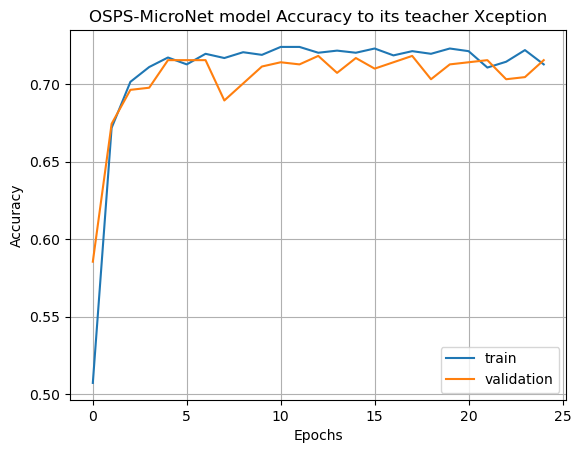

In [10]:
import matplotlib.pyplot as plt

fig1 = plt.gcf()

plt.plot(graph.history['sparse_categorical_accuracy'])
plt.plot(graph.history['val_sparse_categorical_accuracy'])

# plt.axis(ymin=0.4, ymax=1)
plt.grid()

plt.title('OSPS-MicroNet model Accuracy to its teacher Xception')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'])

plt.show()

Train the Teacher Network and Distill the Teacher weights to Student

In [11]:
max_acc = max(graph.history['val_sparse_categorical_accuracy'])
print('The highest accuracy achieved for OSPS-MicroNet model Accuracy to its teacher Xception model is',max_acc*100)

The highest accuracy achieved for OSPS-MicroNet model Accuracy to its teacher Xception model is 71.81942462921143
